## Machine Learning exam, Andrea Milici

In [1]:
from data.DataExplorator import DataExplorator
from data.DataLoader import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from utils.conv import output_dim

import torch
import torch.nn as nn



from utils.seed import set_seed
    

set_seed(42)


In [2]:
# Carica il dataset, di default lo converte in (N,24,15,15) e ritorna un dataframe pandas
dataloader = DataLoader("/auto_atlas/atlas/atlas_gen_fs/amilici/other_samples/ml_exam_dataset/data_quench.json") # transform_to_2d= True di default
data= dataloader.get_data()

# Data exploration

Quench:  [{'step': 6, 'pixel': [1, 10], 'temp': 24.028407932572815}, {'step': 14, 'pixel': [13, 7], 'temp': 24.957035102141912}]


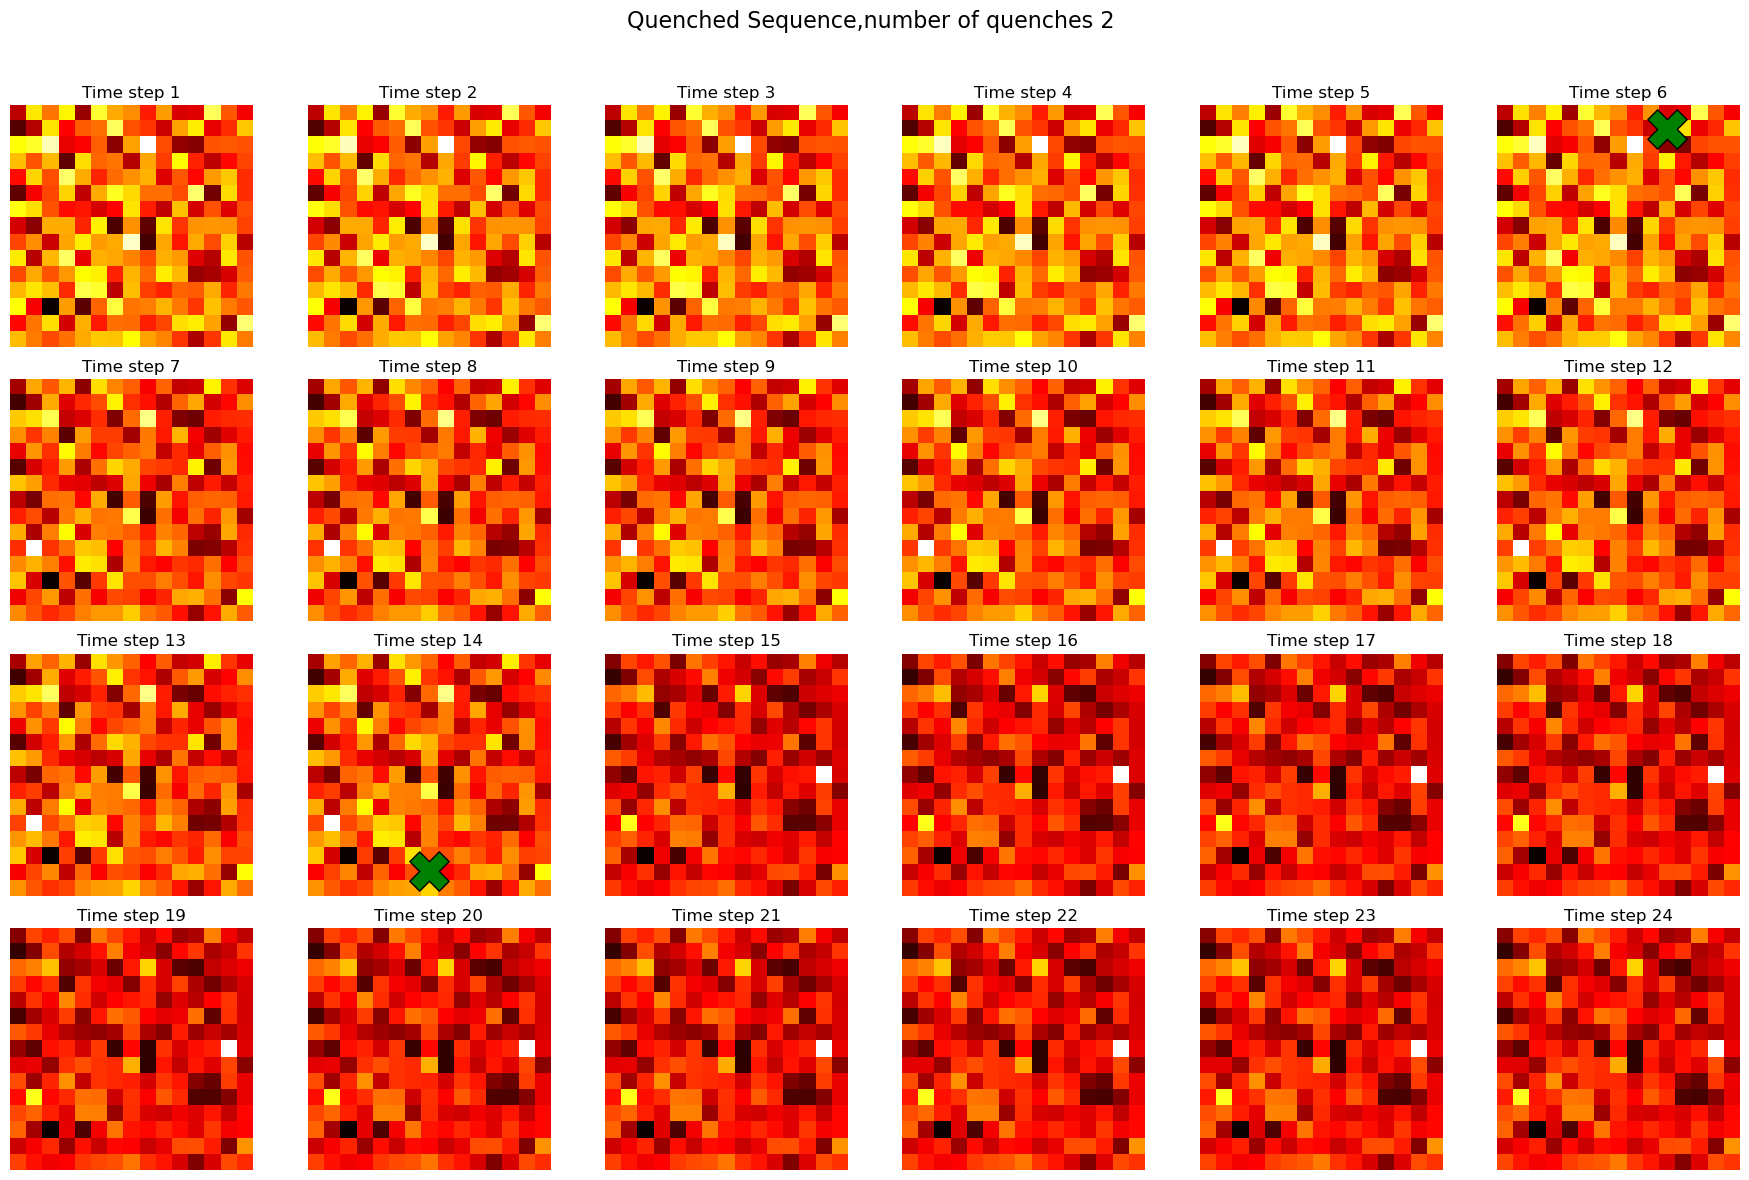

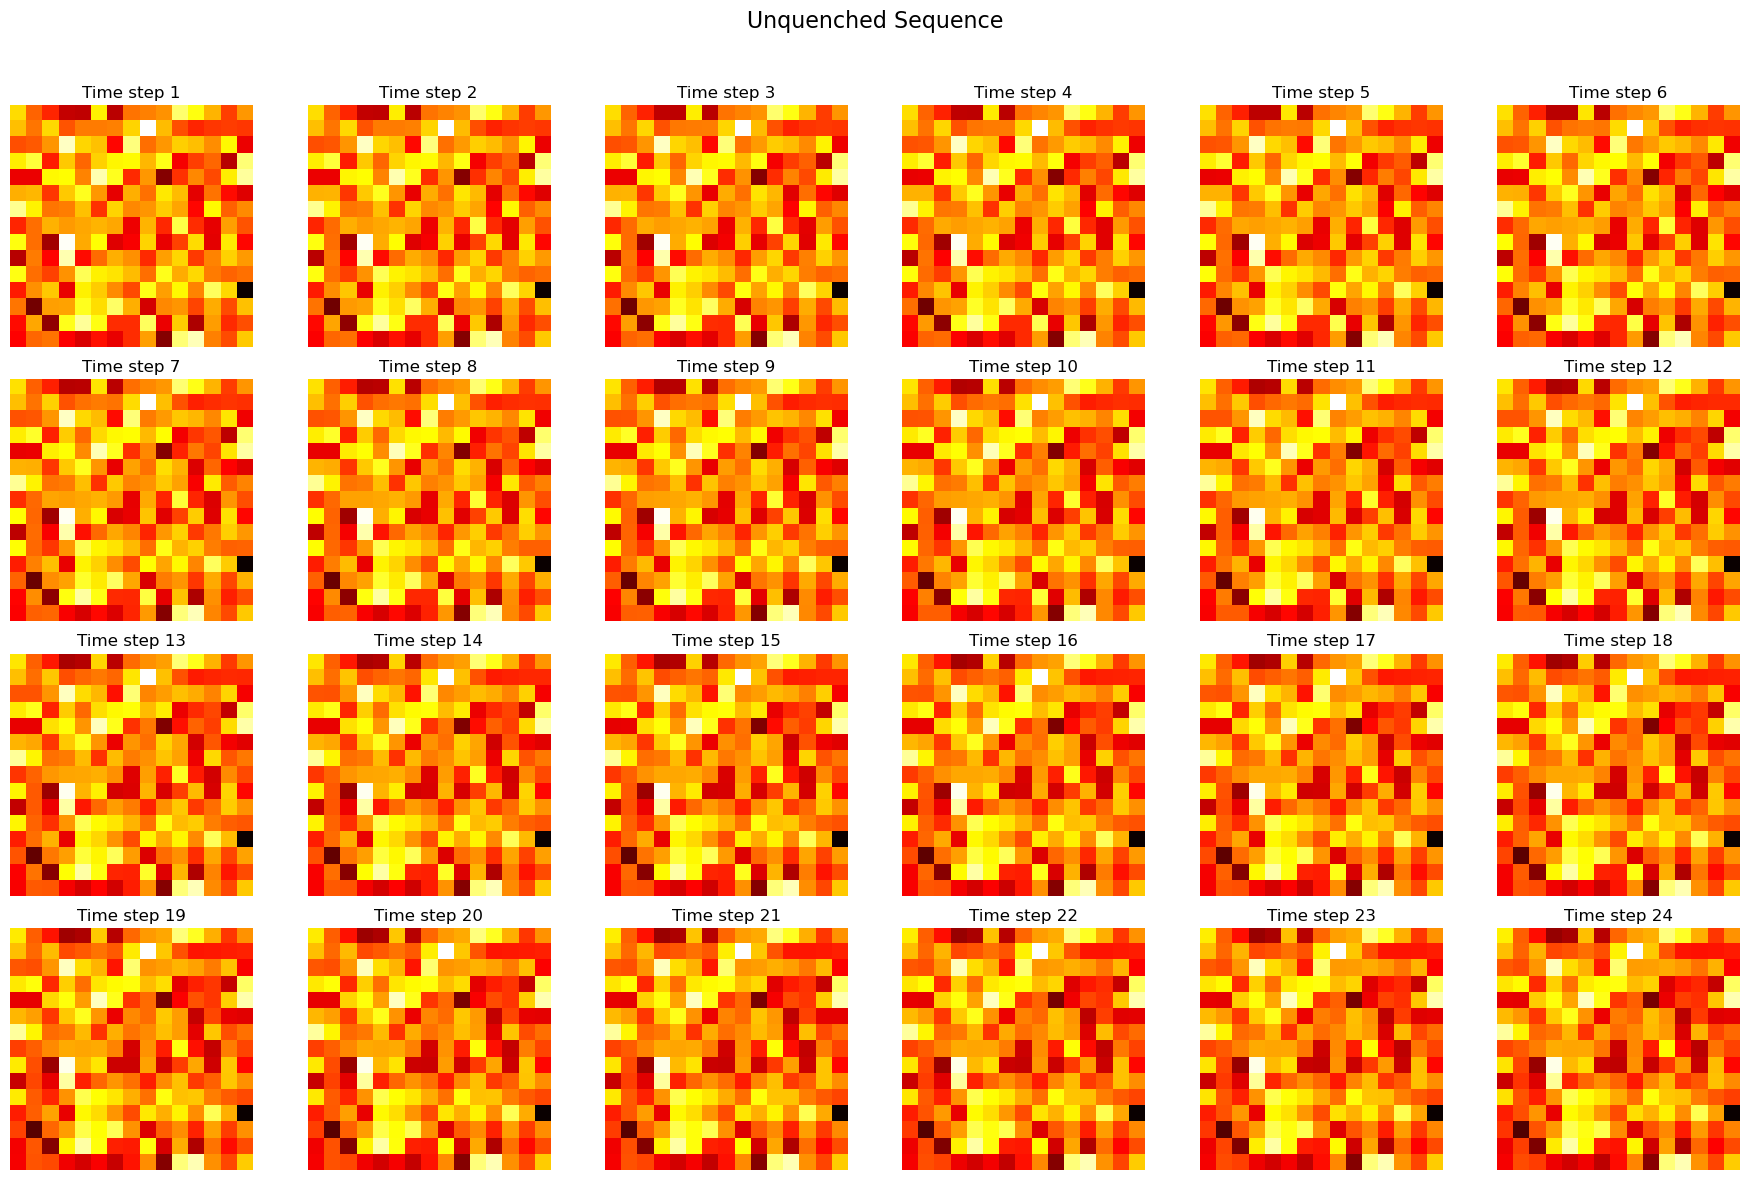

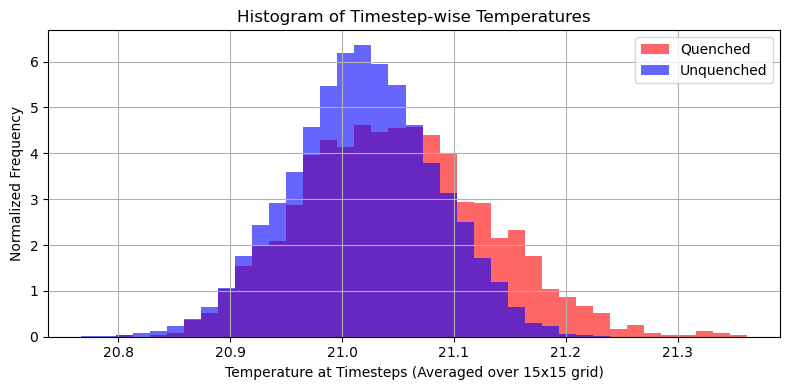

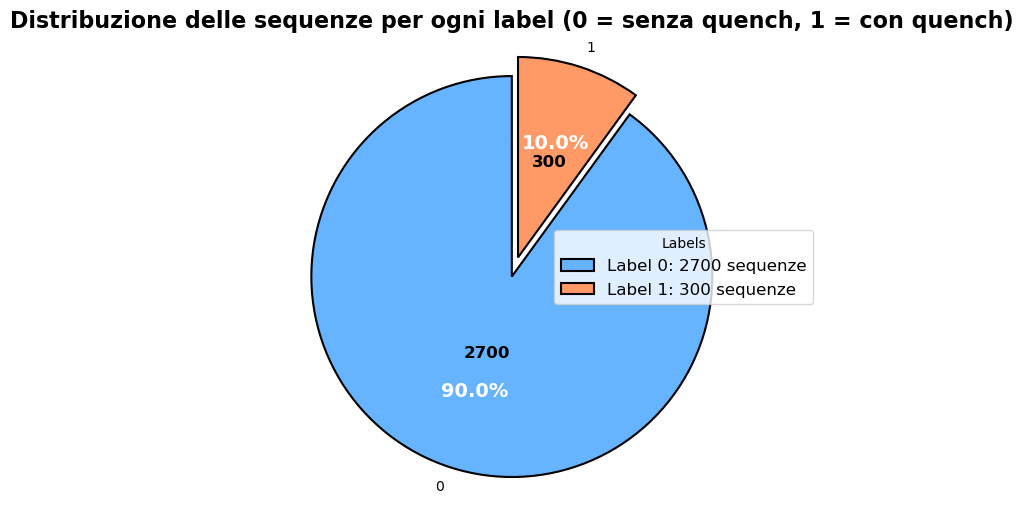

In [3]:
exploration = DataExplorator(data) 
# Vediamo una sequenza di heatmap con label == 1
exploration.visualize_sequence(quenched=True,debug=True)
# Vediamo una sequenza di heatmap con label == 0
exploration.visualize_sequence(quenched=False)
exploration.more_data_exploration()

In [4]:
#Preprocessing: Normalizzazione dei dati
# Trova min e max globali su tutto il dataset

all_values = np.concatenate([sequence.flatten() for sequence in data.sequence])
global_min = np.min(all_values)
global_max = np.max(all_values)
denom = global_max - global_min
data.sequence = (data.sequence- global_min)/denom

In [5]:
from sklearn.utils import resample
import pandas as pd

downsapmping = False

if downsapmping:
    # Esegui il downsampling per bilanciare le classi
    print("Eseguo il downsampling per bilanciare le classi")
    # Supponiamo che df sia il tuo DataFrame con una colonna 'label'
    class0 = data[data.label == 0]
    class1 = data[data.label == 1]

    # Sottocampiona la classe 0
    class0_downsampled = resample(class0, 
                                       replace=False,     # no replacement
                                       n_samples=300,     # come la classe minoritaria
                                       random_state=42)

    # Combina le due classi
    df_balanced = pd.concat([class0_downsampled, class1], ignore_index=True)

    # Shuffle (facoltativo ma consigliato)
    data = df_balanced.sample(frac=1, random_state=42).copy()


In [6]:
from data.torch_Dataset import torch_Dataset
full_dataset = torch_Dataset(data, grid_size=15)


# Creazione del DataLoader
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Train/test split
test_ratio = 0.2
test_size = int(len(full_dataset) * test_ratio)
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
from models.CNN_3D import CNN_3D
model = CNN_3D()
# Definizione della funzione di perdita e dell'ottimizzatore
pos_weight= torch.tensor([len(data[data.label==0])/len(data[data.label==1])])  # Peso per la classe positiva, da regolare in base al dataset
print("Pos weight:", pos_weight)
loss_BCEWithLogits= nn.BCEWithLogitsLoss(pos_weight=None)  # Per classificazione binaria
#loss_BCE= nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Pos weight: tensor([9.])


In [8]:
from utils.model_utils import count_parameters,reset_weights

total_params, trainable_params = count_parameters(model)
print(f"Parametri totali: {total_params}")
print(f"Parametri trainabili: {trainable_params}")



Parametri totali: 4561
Parametri trainabili: 4561


In [9]:
from train.trainer import Trainer
num_epochs=10

model_1 = CNN_3D()
trainer = Trainer(model_1, loss_BCEWithLogits,optimizer='Adam', num_epochs=num_epochs, train_loader=train_loader ,test_loader=test_loader)
results=trainer.run()

/auto_home/users/amilici/ml_exam/quench_project/train/trainer.py:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optimizer is 'Adam':


Epoch 01 | Train Loss: 0.3762 | Test Loss: 0.3791 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 02 | Train Loss: 0.3344 | Test Loss: 0.3582 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 03 | Train Loss: 0.3329 | Test Loss: 0.4012 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 04 | Train Loss: 0.3365 | Test Loss: 0.3108 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 05 | Train Loss: 0.3333 | Test Loss: 0.3766 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 06 | Train Loss: 0.3410 | Test Loss: 0.3381 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 07 | Train Loss: 0.3337 | Test Loss: 0.3773 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 08 | Train Loss: 0.3357 | Test Loss: 0.3589 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 09 | Train Loss: 0.3332 | Test Loss: 0.3564 | Test Acc: 90.83% | Test Prec: 0.00% | Test Recall: 0.00%
Epoch 10 | Train Lo

In [ ]:


train_losses = []
train_losses_per_batch = []
test_losses = []
test_accuracy_per_epoch = []


loss_fn = loss_BCEWithLogits  

for epoch in range(num_epochs):

    

    if epoch ==0:
        model.apply(reset_weights)

    # ---- Training ----

    model.train()
    total_train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        
        loss = loss_fn(preds, batch_y)  
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * batch_x.size(0)
        train_losses_per_batch.append(loss.item())

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    


    # ---- Evaluation ----
    model.eval()
    total_test_loss = 0.0
    correct = 0
    total = 0
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives


    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            
            preds = model(batch_x)
            loss = loss_fn(preds, batch_y)
            total_test_loss += loss.item() * batch_x.size(0)

            probs = torch.sigmoid(preds)
            predicted = (probs >= 0.5).float()
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

            # Precision/Recall
            TP += ((predicted == 1) & (batch_y == 1)).sum().item()
            FP += ((predicted == 1) & (batch_y == 0)).sum().item()
            FN += ((predicted == 0) & (batch_y == 1)).sum().item()
        

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_accuracy = correct / total * 100
    test_precision = 100*(TP / (TP + FP)) if (TP + FP) > 0 else 0
    test_recall = 100*(TP / (TP + FN)) if (TP + FN) > 0 else 0
    
    

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}% | Test Prec: {test_precision:.2f}% | Test Recall: {test_recall:.2f}%" )
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    test_accuracy_per_epoch.append(test_accuracy)
    

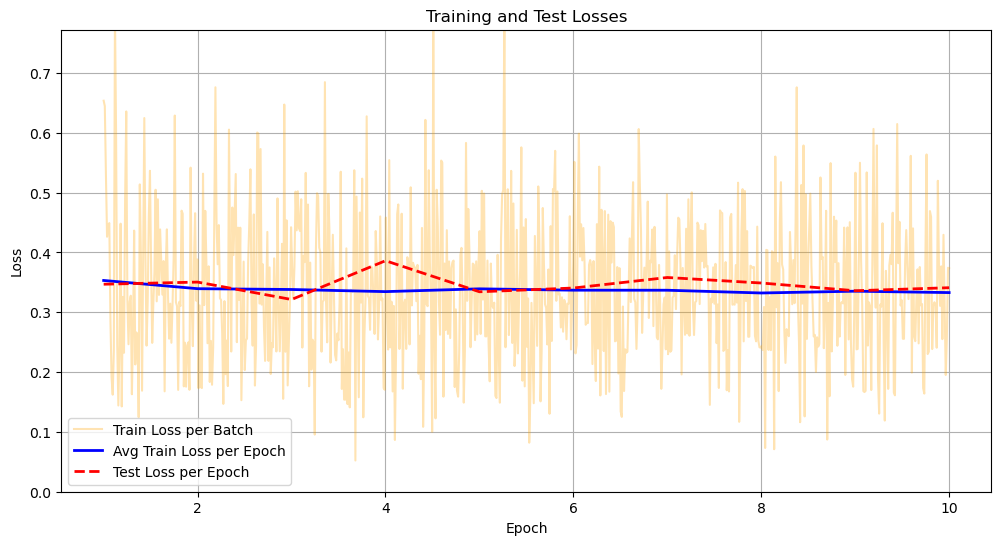

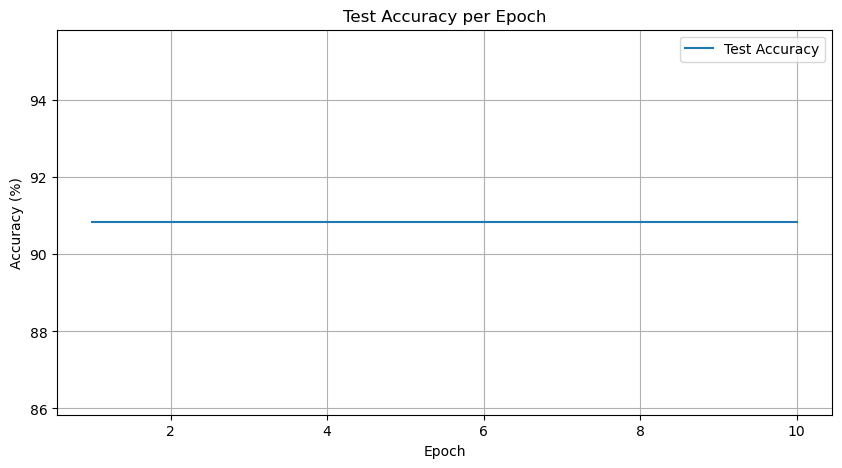

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcola il numero di epoche
num_epochs = len(train_losses)

# Calcola il numero di batch per epoca
num_batches_per_epoch = len(train_losses_per_batch) // num_epochs

# Crea un asse x "frazionario" per le batch, spostato in modo che l'epoca 1 inizi da x=1
batch_x_axis = np.linspace(1, num_epochs, len(train_losses_per_batch))

# Asse x per le medie per epoca, da 1 a num_epochs inclusi
epoch_x_axis = np.arange(1, num_epochs + 1)

# Plotting delle loss
plt.figure(figsize=(12, 6))

# Loss per batch (sfumata)
plt.plot(batch_x_axis, np.array(train_losses_per_batch), label='Train Loss per Batch', alpha=0.3, color='orange')

# Loss medie per epoca
plt.plot(epoch_x_axis, train_losses, label='Avg Train Loss per Epoch', color='blue', linewidth=2)
plt.plot(epoch_x_axis, test_losses, label='Test Loss per Epoch', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses), max(test_losses)) * 2)  # Imposta un limite superiore dinamico
plt.title('Training and Test Losses')
plt.legend()
plt.grid(True)

plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_x_axis, test_accuracy_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
x_all = torch.stack([x for x, y in test_dataset])
y_all = torch.stack([y for x, y in test_dataset])

model.eval()
with torch.no_grad():
    logits = model(x_all)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()



              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       545
         1.0       0.00      0.00      0.00        55

    accuracy                           0.91       600
   macro avg       0.45      0.50      0.48       600
weighted avg       0.83      0.91      0.86       600

[[545   0]
 [ 55   0]]
ROC AUC: 0.4264553794829024


/teo_fs_fast/software/miniforge/envs/amilici_exam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teo_fs_fast/software/miniforge/envs/amilici_exam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/teo_fs_fast/software/miniforge/envs/amilici_exam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

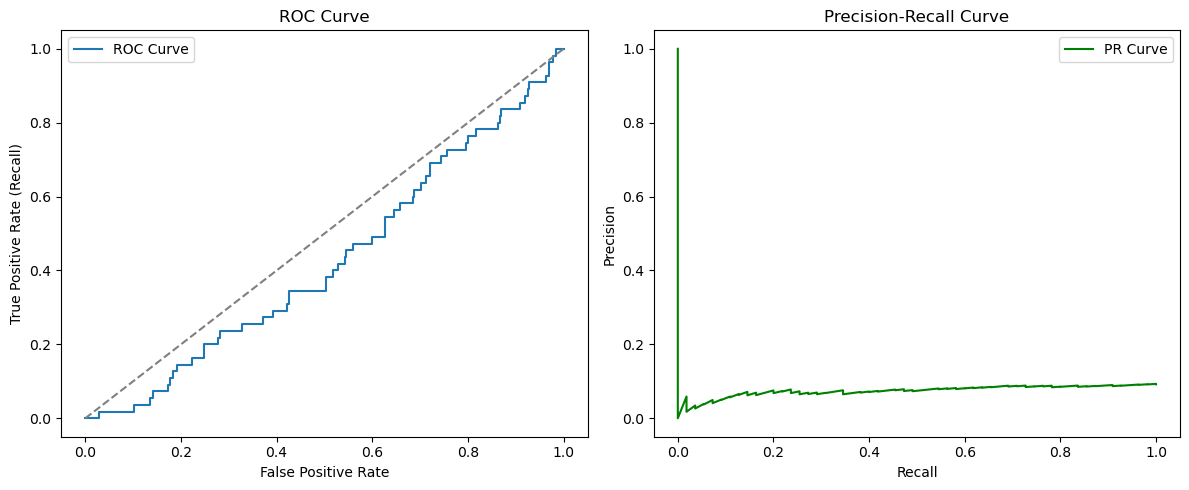

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt



# Classificazione standard
print(classification_report(y_all, preds))
print(confusion_matrix(y_all, preds))

# ROC AUC
print("ROC AUC:", roc_auc_score(y_all,probs))

# Curve
fpr, tpr, _ = roc_curve(y_all, probs)
precision, recall, _ = precision_recall_curve(y_all, probs)

plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1,2,2)
plt.plot(recall, precision, label='PR Curve', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


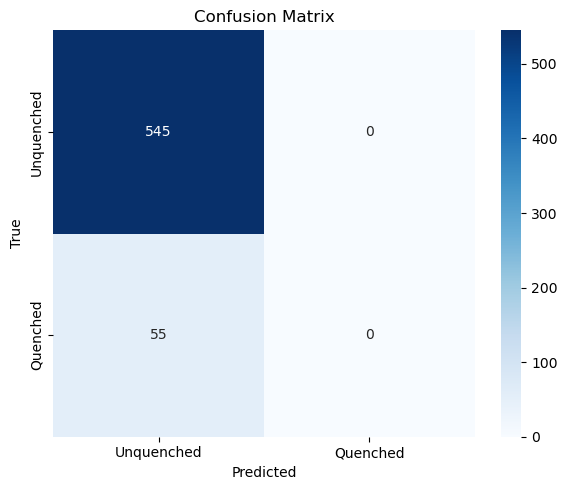

In [ ]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plot a confusion matrix with counts in each cell.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - labels: list of label names, optional
    - title: title of the plot
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_all, preds, labels=["Unquenched", "Quenched"])


